# <u>EDA and Feature Engineering<u>

### Objective:
In this notebook, the data frame will be explored in greater detail. New data columns will be created by doing feature engineering to prepare for the modeling process.

### Importing External Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import collections
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score
from data_preprocessing import *

%matplotlib inline

### Importing clean data

In [4]:
betting_df = pd.read_csv('../Data/betting_df.csv')

### Creating a new over/under result column
- This column will show if the result of the game was over, under, or a push on the expected total points

In [5]:
betting_df['over_under_result'] = np.where(betting_df['total_points']>betting_df['over/under'], 
                                           'over', 'under')
betting_df['over_under_result'] = np.where(betting_df['total_points']==betting_df['over/under'], 
                                           'push', betting_df['over_under_result'])

In [6]:
betting_df.head()

,date,season_year,week,home_team,away_team,stadium,team_favorite,spread,over/under,stadium_type,...,total_score_over_min,total_score_over_max,total_score_over_close,total_score_under_open,total_score_under_min,total_score_under_max,total_score_under_close,score_difference,total_points,over_under_result
0,2014-09-04,2014,1,Seattle Seahawks,Green Bay Packers,CenturyLink Field,SEA,-5.5,46.5,na,...,1.83,2.00,1.98,1.95,1.95,2.00,1.93,20,52,over
1,2014-09-07,2014,1,Atlanta Falcons,New Orleans Saints,Georgia Dome,NO,-3.0,52.0,DOME,...,1.94,2.01,1.96,1.95,1.92,1.97,1.94,3,71,over
2,2014-09-07,2014,1,Baltimore Ravens,Cincinnati Bengals,M&T Bank Stadium,BAL,-1.5,42.5,na,...,1.93,1.98,1.97,1.96,1.97,2.00,1.93,-7,39,under
3,2014-09-07,2014,1,Chicago Bears,Buffalo Bills,Soldier Field,CHI,-6.5,47.0,na,...,1.91,2.10,1.91,2.03,1.91,1.95,2.00,-3,43,under
4,2014-09-07,2014,1,Dallas Cowboys,San Francisco 49ers,Cowboys Stadium,SF,-3.5,51.0,DOME,...,1.93,2.03,2.00,1.93,1.88,1.99,1.91,-11,45,under


### Creating a dummy column for stadium type
- ie. dome, non-dome, rain, snow,and fog

In [7]:
betting_df = pd.get_dummies(betting_df, columns=['stadium_type'])

In [8]:
betting_df.columns = [i.lower().replace(' ', '_') for i in betting_df.columns]

In [9]:
betting_df['stadium_type_na'].sum()

774

In [10]:
#dropping dummy NA column
betting_df = betting_df.drop(columns=['stadium_type_na'])

### Replacing two team's syntax id's to match with the new id 
- San Diego has moved to Los Angeles
- Sant louis has moved to Los Angeles

In [11]:
betting_df.loc[betting_df.team_favorite =='SD','team_favorite'] = 'LAC'
betting_df.loc[betting_df.team_favorite =='SLR','team_favorite'] = 'LAR'

### Dictionary of NFL teams 

In [12]:
nfl_teams = {'San Diego Chargers': 'LAC', 'Indianapolis Colts': 'IND','Washington Redskins': 'WAS', 'Miami Dolphins': 
'MIA', 'Buffalo Bills': 'BUF','Tennessee Oilers': 'TEN', 'Minnesota Vikings': 'MIN', 'Atlanta Falcons': 'ATL',
'New Orleans Saints': 'NO', 'Pittsburgh Steelers': 'PIT','Kansas City Chiefs': 'KC', 'Denver Broncos': 'DEN', 
'New York Giants': 'NYG', 'Houston Oilers': 'TEN','Cleveland Browns': 'CLE', 'Philadelphia Eagles': 'PHI',
'Dallas Cowboys': 'DAL','Arizona Cardinals': 'ARI', 'Chicago Bears': 'CHI', 'New England Patriots': 'NE',
'San Francisco 49ers': 'SF','Tampa Bay Buccaneers': 'TB','Seattle Seahawks': 'SEA','Baltimore Ravens': 'BAL', 
'Jacksonville Jaguars': 'JAX','Carolina Panthers': 'CAR', 'Green Bay Packers': 'GB','St. Louis Cardinals': 'ARI',
'Los Angeles Raiders': 'OAK','Detroit Lions': 'DET','Cincinnati Bengals': 'CIN','Los Angeles Rams': 'LAR',
'Oakland Raiders': 'OAK','Houston Texans': 'HOU', 'Tennessee Titans': 'TEN','New York Jets': 'NYJ',
    'St. Louis Rams': 'LAR', 'Baltimore Colts': 'IND', 'Los Angeles Chargers': 'LAC',
'Phoenix Cardinals': 'ARI'}

#### Mapping the full team name to the teams abbreviation

In [13]:
betting_df['home_id'] = betting_df.home_team.map(nfl_teams)
betting_df['away_id'] = betting_df.away_team.map(nfl_teams)

In [14]:
betting_df.head()

,date,season_year,week,home_team,away_team,stadium,team_favorite,spread,over/under,weather_temperature,...,score_difference,total_points,over_under_result,stadium_type_dome,stadium_type_fog,stadium_type_rain,stadium_type_rain_|_fog,stadium_type_snow,home_id,away_id
0,2014-09-04,2014,1,Seattle Seahawks,Green Bay Packers,CenturyLink Field,SEA,-5.5,46.5,70.0,...,20,52,over,0,0,0,0,0,SEA,GB
1,2014-09-07,2014,1,Atlanta Falcons,New Orleans Saints,Georgia Dome,NO,-3.0,52.0,72.0,...,3,71,over,1,0,0,0,0,ATL,NO
2,2014-09-07,2014,1,Baltimore Ravens,Cincinnati Bengals,M&T Bank Stadium,BAL,-1.5,42.5,78.0,...,-7,39,under,0,0,0,0,0,BAL,CIN
3,2014-09-07,2014,1,Chicago Bears,Buffalo Bills,Soldier Field,CHI,-6.5,47.0,77.0,...,-3,43,under,0,0,0,0,0,CHI,BUF
4,2014-09-07,2014,1,Dallas Cowboys,San Francisco 49ers,Cowboys Stadium,SF,-3.5,51.0,72.0,...,-11,45,under,1,0,0,0,0,DAL,SF


### Making a column for whether or not the home team is the favorite

In [15]:
betting_df['home_favorite'] = 0
betting_df.loc[betting_df.home_id == betting_df.team_favorite,'home_favorite'] = 1
betting_df.head()

,date,season_year,week,home_team,away_team,stadium,team_favorite,spread,over/under,weather_temperature,...,total_points,over_under_result,stadium_type_dome,stadium_type_fog,stadium_type_rain,stadium_type_rain_|_fog,stadium_type_snow,home_id,away_id,home_favorite
0,2014-09-04,2014,1,Seattle Seahawks,Green Bay Packers,CenturyLink Field,SEA,-5.5,46.5,70.0,...,52,over,0,0,0,0,0,SEA,GB,1
1,2014-09-07,2014,1,Atlanta Falcons,New Orleans Saints,Georgia Dome,NO,-3.0,52.0,72.0,...,71,over,1,0,0,0,0,ATL,NO,0
2,2014-09-07,2014,1,Baltimore Ravens,Cincinnati Bengals,M&T Bank Stadium,BAL,-1.5,42.5,78.0,...,39,under,0,0,0,0,0,BAL,CIN,1
3,2014-09-07,2014,1,Chicago Bears,Buffalo Bills,Soldier Field,CHI,-6.5,47.0,77.0,...,43,under,0,0,0,0,0,CHI,BUF,1
4,2014-09-07,2014,1,Dallas Cowboys,San Francisco 49ers,Cowboys Stadium,SF,-3.5,51.0,72.0,...,45,under,1,0,0,0,0,DAL,SF,0


#### Creating a column for whether or not the favorite covered the pre-determined spread
- if the score difference is negative that means the favorite los
- if the score difference is positive favorite won but doesn't mean they beat the betting lines
- checking favorite's win margin against the spread to see if they beat the spread as well
    - 0 means home favorite lost 
    - 1 means home favorite won and covered spread
    - 2 means away favorite lost

#### Creating a column for who won the game not including spread

In [16]:
betting_df['favorite_covered'] = np.where((betting_df.home_favorite==1) & 
                                          (np.abs(betting_df.score_difference) > np.abs(betting_df.spread)),1,0)
betting_df['favorite_covered'] = np.where((np.abs(betting_df.score_difference) == np.abs(betting_df.spread)),'2',
                                          betting_df.favorite_covered)

In [17]:
# Converting to integers
betting_df['favorite_covered']= betting_df['favorite_covered'].astype("int64")

In [18]:
betting_df.columns

Index(['date', 'season_year', 'week', 'home_team', 'away_team', 'stadium',
       'team_favorite', 'spread', 'over/under', 'weather_temperature',
       'weather_wind_mph', 'weather_humidity', 'score_home', 'score_away',
       'overtime?', 'playoff_game?', 'home_odds_open', 'home_odds_min',
       'home_odds_max', 'home_odds_close', 'away_odds_open', 'away_odds_min',
       'away_odds_max', 'away_odds_close', 'home_line_open', 'home_line_min',
       'home_line_max', 'home_line_close', 'away_line_open', 'away_line_min',
       'away_line_max', 'away_line_close', 'home_line_odds_open',
       'home_line_odds_min', 'home_line_odds_max', 'home_line_odds_close',
       'away_line_odds_open', 'away_line_odds_min', 'away_line_odds_max',
       'away_line_odds_close', 'total_score_open', 'total_score_min',
       'total_score_max', 'total_score_close', 'total_score_over_open',
       'total_score_over_min', 'total_score_over_max',
       'total_score_over_close', 'total_score_under_open',
  

In [19]:
# creating winners column
betting_df['winner'] = ''
betting_df['winner'] = np.where(betting_df.score_home > betting_df.score_away, betting_df.home_id, betting_df.away_id)
betting_df['winner'] = np.where(betting_df.score_home == betting_df.score_away, 'tie', betting_df.winner)

In [20]:
# creating losers column
betting_df['loser'] = ''
betting_df['loser'] = np.where(betting_df.score_home < betting_df.score_away, betting_df.home_id, betting_df.away_id)
betting_df['loser'] = np.where(betting_df.score_home == betting_df.score_away, 'tie', betting_df.loser)

In [21]:
betting_df.head()

,date,season_year,week,home_team,away_team,stadium,team_favorite,spread,over/under,weather_temperature,...,stadium_type_fog,stadium_type_rain,stadium_type_rain_|_fog,stadium_type_snow,home_id,away_id,home_favorite,favorite_covered,winner,loser
0,2014-09-04,2014,1,Seattle Seahawks,Green Bay Packers,CenturyLink Field,SEA,-5.5,46.5,70.0,...,0,0,0,0,SEA,GB,1,1,SEA,GB
1,2014-09-07,2014,1,Atlanta Falcons,New Orleans Saints,Georgia Dome,NO,-3.0,52.0,72.0,...,0,0,0,0,ATL,NO,0,2,ATL,NO
2,2014-09-07,2014,1,Baltimore Ravens,Cincinnati Bengals,M&T Bank Stadium,BAL,-1.5,42.5,78.0,...,0,0,0,0,BAL,CIN,1,1,CIN,BAL
3,2014-09-07,2014,1,Chicago Bears,Buffalo Bills,Soldier Field,CHI,-6.5,47.0,77.0,...,0,0,0,0,CHI,BUF,1,0,BUF,CHI
4,2014-09-07,2014,1,Dallas Cowboys,San Francisco 49ers,Cowboys Stadium,SF,-3.5,51.0,72.0,...,0,0,0,0,DAL,SF,0,0,SF,DAL


### Making a running total win rate for each team

#### Creating an NFL teams data frame

In [22]:
team_df = pd.DataFrame([{'name' : name, 'id' : id} for name, id in nfl_teams.items()])

In [23]:
team_df.head()

,id,name
0,LAC,San Diego Chargers
1,IND,Indianapolis Colts
2,WAS,Washington Redskins
3,MIA,Miami Dolphins
4,BUF,Buffalo Bills


#### Defining Running Win Rate Function

In [24]:
def running_win_rate(betting_df, team_id):
    try:
        games = betting_df['home_id'][betting_df['home_id'] == team_id].count() + betting_df['away_id'][betting_df['away_id'] == team_id].count()
        wins  = betting_df['winner'][betting_df['winner'] == team_id].count()
    except:
        return None
        
    if games == 0:
        return 0

#     team_df['losses'] = team_df['games'] - team_df['wins']
    win_rate = wins / games
    return win_rate
    

In [25]:
running_win_rate(betting_df[0:0], 'GB')

0

In [26]:
betting_df['home_win_rate'] = np.nan

In [27]:
for i, row in betting_df.iterrows():
    home_win_rate = running_win_rate(betting_df[:i+1], row['home_id'])
    away_win_rate = running_win_rate(betting_df[:i+1], row['away_id'])
#     print(win_rate)
    
    betting_df.loc[i, 'home_win_rate'] = home_win_rate
    betting_df.loc[i, 'away_win_rate'] = away_win_rate    
#     betting_df['away_win_rate']

In [28]:
betting_df[['home_id', 'away_id', 'winner', 'home_win_rate', 'away_win_rate']].head(10)

,home_id,away_id,winner,home_win_rate,away_win_rate
0,SEA,GB,SEA,1.0,0.0
1,ATL,NO,ATL,1.0,0.0
2,BAL,CIN,CIN,0.0,1.0
3,CHI,BUF,BUF,0.0,1.0
4,DAL,SF,SF,0.0,1.0
5,DEN,IND,DEN,1.0,0.0
6,HOU,WAS,HOU,1.0,0.0
7,KC,TEN,TEN,0.0,1.0
8,MIA,NE,MIA,1.0,0.0
9,NYJ,OAK,NYJ,1.0,0.0


### Creating cumulative average total points
- will help predict future total

In [29]:
betting_df['cum_avg_points'] = 0
for i,num in enumerate(betting_df['total_points']):
    if i == 0:
        betting_df['cum_avg_points'][i] = 0
    else:
        betting_df.loc[i,'cum_avg_points'] = betting_df.loc[:i-1, 'total_points'].mean()
        
    

/anaconda3/envs/dsi/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [30]:
betting_df[['total_points', 'cum_avg_points']].head(10)

,total_points,cum_avg_points
0,52,0.000000
1,71,52.000000
2,39,61.500000
3,43,54.000000
4,45,51.250000
5,55,50.000000
6,23,50.833333
7,36,46.857143
8,53,45.500000
9,33,46.333333


In [31]:
betting_df[['total_points','over/under', 'cum_avg_points']].describe()

,total_points,over/under,cum_avg_points
count,1068.000000,1068.000000,1068.000000
mean,45.024345,45.303371,45.485797
std,13.728160,3.943035,1.617205
min,6.000000,36.500000,0.000000
25%,35.000000,42.500000,45.325330
50%,44.000000,45.000000,45.433472
75%,54.000000,48.000000,45.594905
max,101.000000,59.500000,61.500000


(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        6.000e+00, 1.055e+03, 5.000e+00, 1.000e+00]),
 array([ 0.  ,  6.15, 12.3 , 18.45, 24.6 , 30.75, 36.9 , 43.05, 49.2 ,
        55.35, 61.5 ]),
 <a list of 10 Patch objects>)

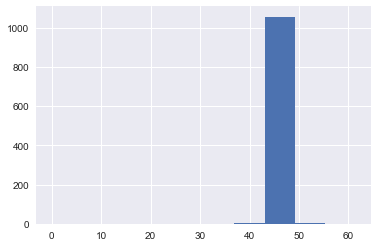

In [32]:
plt.hist(betting_df['cum_avg_points'])

In [33]:
# value counts
betting_df['over_under_result'].value_counts(normalize=True)

under    0.511236
over     0.475655
push     0.013109
Name: over_under_result, dtype: float64

In [34]:
betting_df['over_under_result'].isna().sum()

0

In [35]:
# dropping pushes 
betting_df = betting_df.drop(betting_df[betting_df['over_under_result'] == 'push'].index, axis = 0) 



In [36]:
# value counts
betting_df['over_under_result'].value_counts(normalize=True)

under    0.518027
over     0.481973
Name: over_under_result, dtype: float64

### Creating target variable

In [37]:
betting_df['target'] = betting_df['over_under_result'].apply(lambda x: 1 if x == 'over' else 0 )

In [38]:
betting_df.head()

,date,season_year,week,home_team,away_team,stadium,team_favorite,spread,over/under,weather_temperature,...,home_id,away_id,home_favorite,favorite_covered,winner,loser,home_win_rate,away_win_rate,cum_avg_points,target
0,2014-09-04,2014,1,Seattle Seahawks,Green Bay Packers,CenturyLink Field,SEA,-5.5,46.5,70.0,...,SEA,GB,1,1,SEA,GB,1.0,0.0,0.00,1
1,2014-09-07,2014,1,Atlanta Falcons,New Orleans Saints,Georgia Dome,NO,-3.0,52.0,72.0,...,ATL,NO,0,2,ATL,NO,1.0,0.0,52.00,1
2,2014-09-07,2014,1,Baltimore Ravens,Cincinnati Bengals,M&T Bank Stadium,BAL,-1.5,42.5,78.0,...,BAL,CIN,1,1,CIN,BAL,0.0,1.0,61.50,0
3,2014-09-07,2014,1,Chicago Bears,Buffalo Bills,Soldier Field,CHI,-6.5,47.0,77.0,...,CHI,BUF,1,0,BUF,CHI,0.0,1.0,54.00,0
4,2014-09-07,2014,1,Dallas Cowboys,San Francisco 49ers,Cowboys Stadium,SF,-3.5,51.0,72.0,...,DAL,SF,0,0,SF,DAL,0.0,1.0,51.25,0


### Examaning Correlations

- Created a correlation heatmap to find the strongest correlations with over/under and target

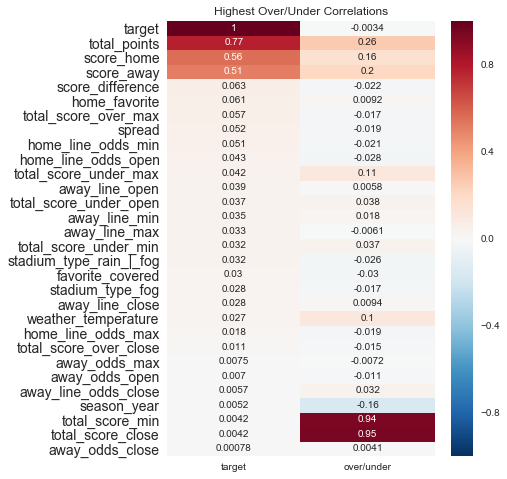

In [39]:
plt.figure(figsize=(6,8))
ax = sns.heatmap(betting_df.corr()[['target', 'over/under']].sort_values('target',ascending=False)[:30],annot=True)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)
plt.title('Highest Over/Under Correlations');

-  Features are not highly correlated, which is a bit unexpected will need to take a deeper look into each feature to see if there is some hidden value in them.

### Visualizations
 - Getting an in-depth look into a few features that could be the most correlated when related to the over/under lines

#### Examining temperature's affect on points scored
- Intuition is that cold weather affects player performance  as well as affects the psi of the football
- In cold weather NFL teams are also more likely to run the ball

Text(0, 0.5, 'Total Points')

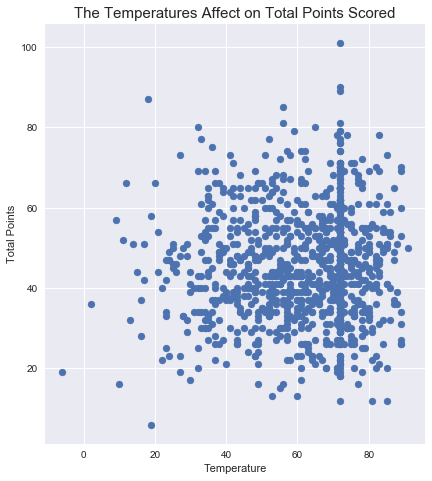

In [46]:
plt.figure(figsize = (15,17))

ax1 = plt.subplot(221)
ax1.set_title('The Temperatures Affect on Total Points Scored', fontsize=15)
ax1.scatter(betting_df['weather_temperature'], betting_df['total_points'])
plt.xlabel('Temperature')
plt.ylabel('Total Points')

#### Examining how close vegas set over/under is to the actual total points
- The visual below shows a very saturated point of interest on 45 points 
- This conveys how accurate the set over/under is for each game versus total points scored, which makes it difficult to predict if the total points will be over/under

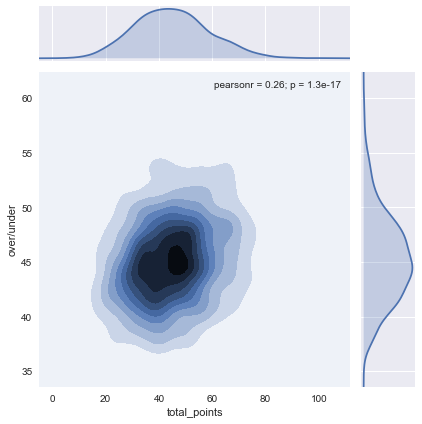

In [43]:
sns.jointplot(x="total_points", y="over/under", data=betting_df, kind="kde");

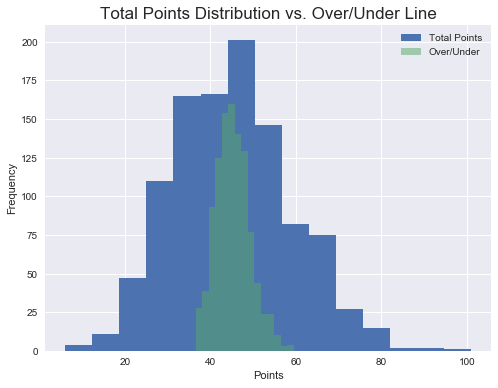

In [74]:
plt.figure(figsize=(8,6))
plt.hist(betting_df['total_points'], bins= 15, label='Total Points')
plt.hist(betting_df['over/under'], bins= 15, alpha=0.5, label='Over/Under')
plt.xlabel('Points')
plt.ylabel('Frequency')
plt.title('Total Points Distribution vs. Over/Under Line', fontsize=17)
plt.legend(loc='upper right');

#### Analyzing the affect of high winds on points scored
- when their is high wind in an NFL game it makes it harder to make accurate passes
- There is a slight downward trend when there is high wind, however there are not as many high wind games within the data to portay an accurate depiction.

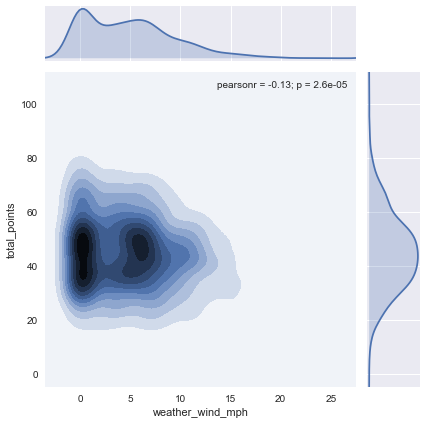

In [44]:
sns.jointplot(x="weather_wind_mph", y="total_points", data=betting_df, kind="kde");

#### Taking a close look into wind mph compared to points

/anaconda3/envs/dsi/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


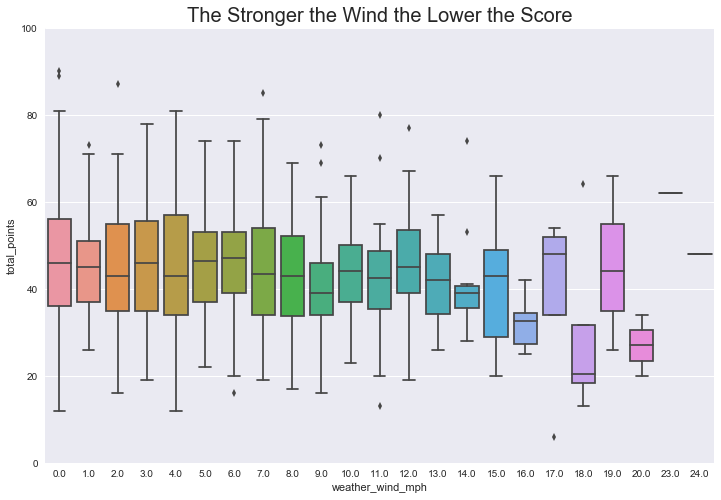

In [37]:
var = 'weather_wind_mph'
data = pd.concat([betting_df['total_points'], betting_df[var]], axis=1)
f, ax =plt.subplots(figsize=(12,8))
fig = sns.boxplot(x=var, y='total_points', data=data)
plt.title('The Stronger the Wind the Lower the Score', fontsize=20)
fig.axis(ymin=0, ymax=100)
plt.show();

#### Examining total points scored per game
- From the graph below shows average total points is around 45 total points per game
- Follows a normal distribution
- This is good depiction of having enough sufficient data as the NFL game average is actaully 43 total points

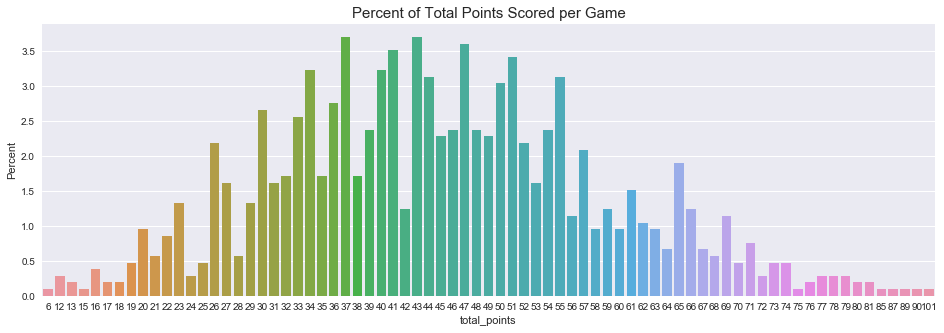

In [122]:
plt.figure(figsize=(16,5))
ax = sns.barplot(x="total_points", y="total_points", data=betting_df, estimator=lambda x: len(x) / len(betting_df) * 100)
ax.set(ylabel="Percent")
plt.title('Percent of Total Points Scored per Game', fontsize=15);


/anaconda3/envs/dsi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


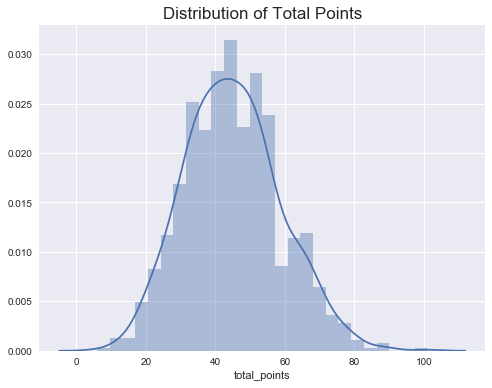

In [40]:
plt.figure(figsize=(8,6))
sns.distplot(betting_df['total_points'], kde=True)
plt.title('Distribution of Total Points', fontsize=17);

In [41]:
betting_df['total_points'].mean()

45.007590132827325

/anaconda3/envs/dsi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


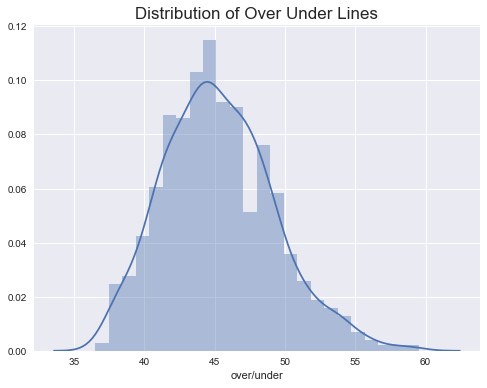

In [58]:
plt.figure(figsize=(8,6))
sns.distplot(betting_df['over/under'])
plt.title('Distribution of Over Under Lines', fontsize=17);

### Saving Data

In [75]:
betting_df.to_csv('../Data/betting_df_processed.csv', index=False)